In [1]:
%load_ext autoreload
%autoreload 2

Normal Limit Distribution
---

0.243882417678833


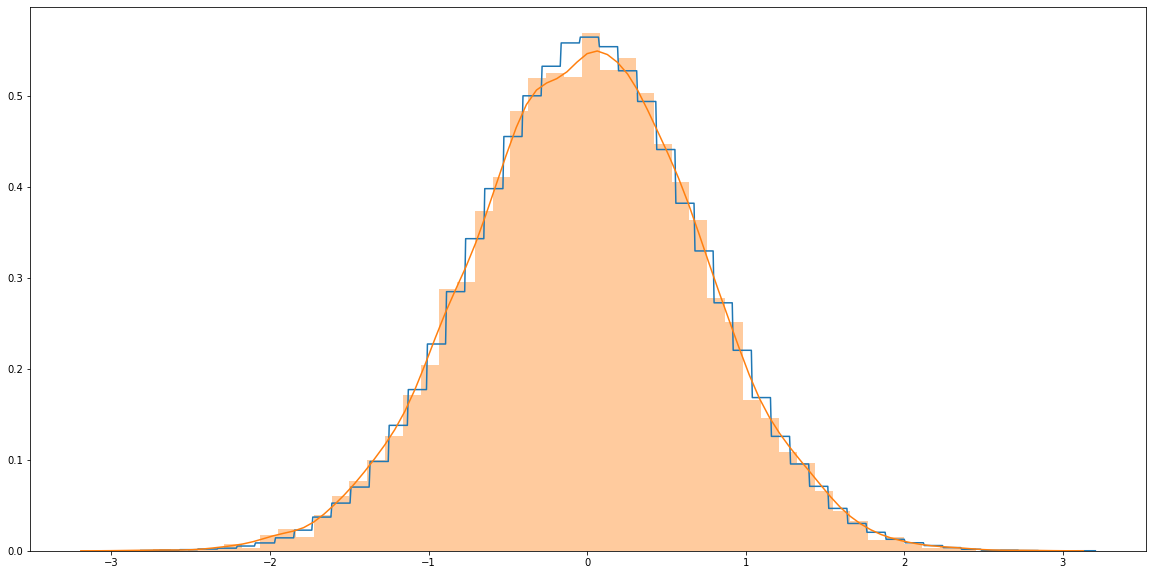

In [2]:
from sdepy.master import run
from sdepy.sde.ito import Ito1D
from sdepy.pdf.histogram import Simple1DHistogram
from sdepy.core import Job
import functions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time


T = 0.5
sde = Ito1D(particles=25000,
            x0=0.0,
            drift=functions.drift,
            diffusion=functions.diffusion,
            sigma=1,
            t0=0.0,
            dt=1e-2,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=50),
    mode=Job.RAW,
    settings={}
)

result, execution_time = run(job, processes=4, parent=functions.__file__)
pdf = result.distributions[-1]

print(execution_time)

x = np.linspace(pdf.lower_bound, pdf.upper_bound, 1000)
y = pdf(x)

plt.figure(figsize=(20, 10))
plt.plot(x, y, label="Approximation")
sb.distplot(np.random.normal(0, np.sqrt(T), size=10000), label="True")
plt.show()


Exponential Limit Distribution
---

1.4300658702850342


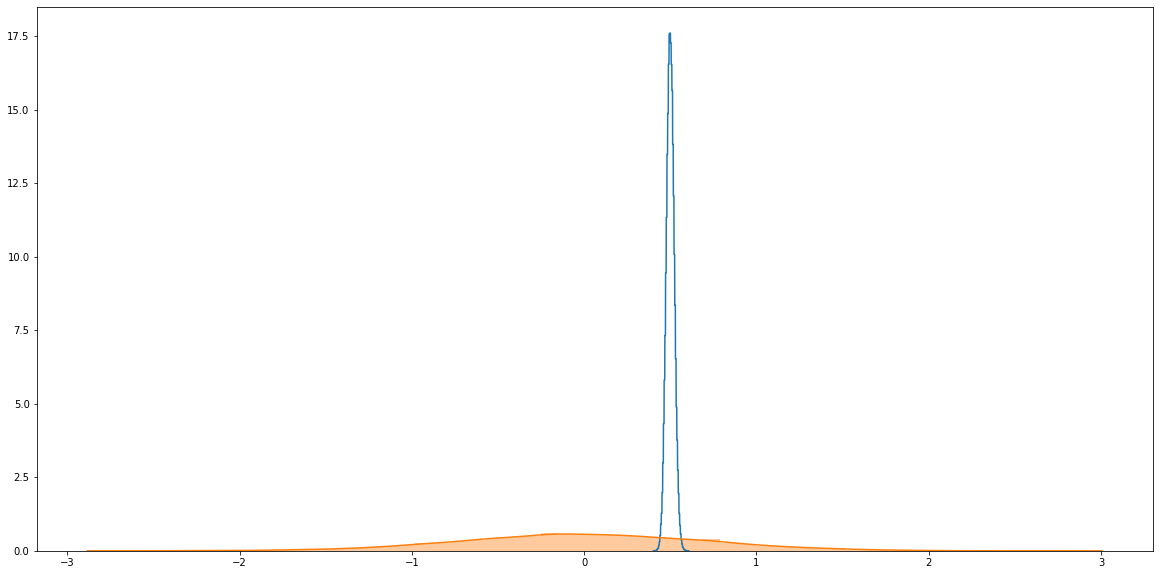

In [5]:
from sdepy.sde.exp import Exp1D


T = 0.5
sde = Exp1D(particles=25000,
            x0=0.0,
            drift=functions.drift,
            diffusion=functions.diffusion,
            lam=1,
            t0=0.0,
            dt=1e-3,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=50),
    mode=Job.RAW,
    settings={}
)


result, execution_time = run(job, processes=4, parent=functions.__file__)
pdf = result.distributions[-1]

print(execution_time)


x = np.linspace(pdf.lower_bound, pdf.upper_bound, 1000)
y = pdf(x)

plt.figure(figsize=(20, 10))
plt.plot(x, y, label="Approximation")
sb.distplot(np.random.normal(0, np.sqrt(T), size=10000), label="True")
plt.show()


Some Normal Process
---

In [3]:
from sdepy.video import make_time_1dx_distplot_video
from IPython.display import HTML
import matplotlib.pyplot as plt
import functions


print(functions.drift(2, 2))

T = 0.5
dt = 1e-3
sde = Ito1D(particles=25000,
            x0=0.0,
            drift=functions.drift,
            diffusion=functions.diffusion,
            sigma=1,
            t0=0.0,
            dt=dt,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=50),
    mode=Job.Video,
    settings={"steps_per_frame": 5}
)

result, _ = run(job, processes=2)
result = result.distributions

anim = make_time_1dx_distplot_video(result, fps=10, dt=dt, steps_per_frame=5, save=True)
anim.fps = 10
anim.bitrate = 1800

plt.close()


HTML(anim.to_html5_video())

0


Some Exponential Process
---

In [4]:
from sdepy.video import make_time_1dx_distplot_video
from IPython.display import HTML
import matplotlib.pyplot as plt
import functions


print(functions.drift(2, 2))

T = 0.5
dt = 1e-3
sde = Exp1D(particles=25000,
            x0=0.0,
            drift=functions.drift,
            diffusion=functions.diffusion,
            lam=1,
            t0=0.0,
            dt=dt,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=50),
    mode=Job.Video,
    settings={"steps_per_frame": 5}
)

result, _ = run(job, processes=2)
result = result.distributions

anim = make_time_1dx_distplot_video(result, fps=10, dt=dt, steps_per_frame=5, save=True)
anim.fps = 10
anim.bitrate = 1800

plt.close()


HTML(anim.to_html5_video())

0


Modelling Corona with exponential process
---

In [50]:
from sdepy.video import make_time_1dx_distplot_video
from IPython.display import HTML
import matplotlib.pyplot as plt
import functions

functions.has_been_sick = None

T = 365 * 2
dt = 1.0
sde = Exp1D(particles=25000,
            x0=5.0,
            drift=functions.covid_drift,
            diffusion=functions.covid_diffusion,
            lam=1.0,
            t0=0.0,
            dt=dt,
            T=T)

job = Job(
    sde=sde,
    pdf=Simple1DHistogram(bins=50),
    mode=Job.Video,
    settings={"steps_per_frame": 5}
)

result, _ = run(job, processes=4)
result = result.distributions

anim = make_time_1dx_distplot_video(result, fps=10, dt=dt, steps_per_frame=5, save=True)
anim.fps = 10
anim.bitrate = 1800

plt.close()


HTML(anim.to_html5_video())

100%|██████████| 200/200 [01:06<00:00,  3.01it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: closed only implemented for datetimelike and offset based windows

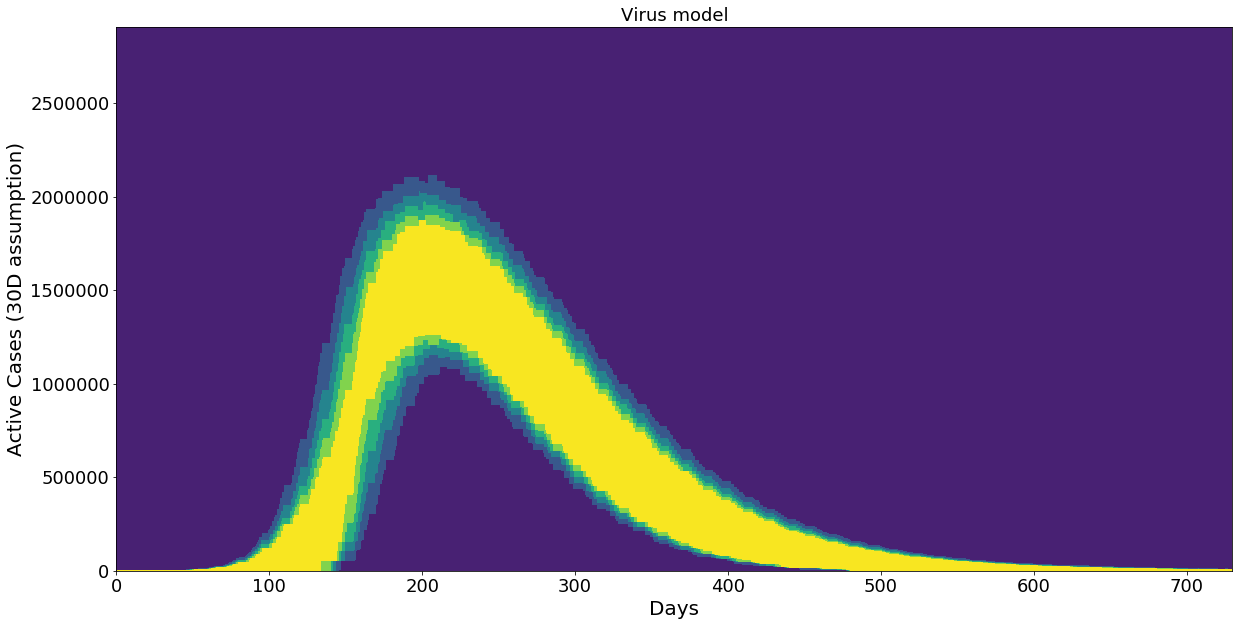

In [71]:
from sdepy.video import three_dee_plot
import pandas as pd


tdplot = three_dee_plot(result, dt=dt, steps_per_frame=5, save=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Days", fontsize=20)
plt.ylabel("Active Cases (30D assumption)", fontsize=20)


corona = pd.read_csv("corona.csv")

def days_infection_max(country: str):

    swe = corona.loc[corona.geoId == country]
    swe["dateRep"] = pd.to_datetime(swe.dateRep)
    swe = swe.sort_values(by="dateRep")
    cum_cases = swe.cases.rolling(30).sum()
    
    return np.arange(cum_cases.size), cum_cases, cum_cases.max()

countries = [
    "SE",
]

my = 0
for country in countries:
    x, y, m = days_infection_max(country)

    plt.plot(x, y, label=country)
    
    my = max([my, m])

plt.ylim([0, my * 2])
plt.xlim([0, 140])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=18)
plt.savefig("corona-virus-country-compare.png", bbox_inches="tight")
plt.show()



In [58]:
corona.geoId.unique()

array(['AF', 'AL', 'DZ', 'AD', 'AO', 'AI', 'AG', 'AR', 'AM', 'AW', 'AU',
       'AT', 'AZ', 'BS', 'BH', 'BD', 'BB', 'BY', 'BE', 'BZ', 'BJ', 'BM',
       'BT', 'BO', 'BQ', 'BA', 'BW', 'BR', 'VG', 'BN', 'BG', 'BF', 'BI',
       'KH', 'CM', 'CA', 'CV', 'JPG11668', 'KY', 'CF', 'TD', 'CL', 'CN',
       'CO', 'CG', 'CR', 'CI', 'HR', 'CU', 'CW', 'CY', 'CZ', 'CD', 'DK',
       'DJ', 'DM', 'DO', 'EC', 'EG', 'SV', 'GQ', 'ER', 'EE', 'SZ', 'ET',
       'FK', 'FO', 'FJ', 'FI', 'FR', 'PF', 'GA', 'GM', 'GE', 'DE', 'GH',
       'GI', 'EL', 'GL', 'GD', 'GU', 'GT', 'GG', 'GN', 'GW', 'GY', 'HT',
       'VA', 'HN', 'HU', 'IS', 'IN', 'ID', 'IR', 'IQ', 'IE', 'IM', 'IL',
       'IT', 'JM', 'JP', 'JE', 'JO', 'KZ', 'KE', 'XK', 'KW', 'KG', 'LA',
       'LV', 'LB', 'LR', 'LY', 'LI', 'LT', 'LU', 'MG', 'MW', 'MY', 'MV',
       'ML', 'MT', 'MR', 'MU', 'MX', 'MD', 'MC', 'MN', 'ME', 'MS', 'MA',
       'MZ', 'MM', nan, 'NP', 'NL', 'NC', 'NZ', 'NI', 'NE', 'NG', 'MK',
       'MP', 'NO', 'OM', 'PK', 'PS', 'PA', 'PG', 'PY

In [74]:
a = pd.DataFrame({"a": np.ones(100)})

list(a.a.rolling(30).sum())

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0]